# Part a) SGD


In [1]:
import numpy as np
import pandas as pd
from imageio import imread
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import os
from common import *
from models import own_LinRegGD
import cv2

print(f"Root directory: {os.getcwd()}")
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
    "font.size": 10,
})

#%matplotlib

Root directory: /home/arefrode/uio/fys-stk4155/projects/FYS-STK4155-Prj2_report/code


# Global variables

In [2]:
SEED_VALUE = 70707070
np.random.seed(SEED_VALUE)
SAVE_FIGURES = False

# Reading data and resizing

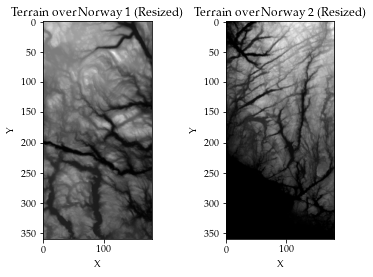

In [3]:
# Load the terrain
terrain1_file = "SRTM_data_Norway_1.tif"
terrain2_file = "SRTM_data_Norway_2.tif"
terrain1 =  imread(f'{INPUT_DATA}{terrain1_file}')
terrain2 = imread(f'{INPUT_DATA}{terrain2_file}')

# Resizing the image
rescale_factor = 0.1
y_size = int(terrain1.shape[0] * rescale_factor)
x_size = int(terrain1.shape[1] * rescale_factor)
terrain1Resized = cv2.resize(terrain1, (x_size, y_size))
terrain2Resized = cv2.resize(terrain2, (x_size, y_size))

# Plotting terrain
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.title.set_text("Terrain over Norway 1 (Resized)")
ax1.set_xlabel("X"); ax1.set_ylabel("Y")
surf1 = ax1.imshow(terrain1Resized, cmap='gray')
ax2.title.set_text("Terrain over Norway 2 (Resized)")
ax2.set_xlabel("X"); ax2.set_ylabel("Y")
surf2 = ax2.imshow(terrain2Resized, cmap='gray')

if SAVE_FIGURES:
    plt.savefig(f"{REPORT_FIGURES}{EX_A}terrain_data_resized.pdf")
plt.show()

# Creating image patches and Terrain data selection

In [4]:
nXpatches = 3; nYpatches=6
y_steps = int(terrain2Resized.shape[0] / nYpatches); print(y_steps)
x_steps = int(terrain2Resized.shape[1] / nXpatches); print(x_steps)

patches_1 = create_img_patches(terrain1Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig1 = plotTerrainPatches(patches_1, nYpatches, nXpatches, plotTitle="Terrain1 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain1_patches.pdf")
    plt.show()

patches_2 = create_img_patches(terrain2Resized, y_steps, x_steps)
if SAVE_FIGURES:
    fig2 = plotTerrainPatches(patches_2, nYpatches, nXpatches, plotTitle="Terrain2 patches")
    plt.savefig(f"{REPORT_FIGURES}{EX_A}Terrain2_patches.pdf")
    plt.show()

# Choosing two interesting terrain patches
img1 = patches_1[2]
img2 = patches_2[5]
x1, y1, z1 = createTerrainData(img1)
x2, y2, z2 = createTerrainData(img2)

# Constructing the terrain data
terrain_data = 1
if terrain_data == 1: # Choosing terrain1*
    x, y, z = x1, y1, z1.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z1

elif terrain_data == 2: # Choosing terrain2
    x, y, z = x2, y2, z2.copy() 
    #z_min = np.min(z)
    z_max = np.max(z)
    z = z2
    
z_flat = z.ravel(); z_flat = z_flat.reshape(-1,1)

60
60


# SGD

In [9]:
from sklearn.linear_model import SGDRegressor

degree = 5
X = create_X(x,y, n=degree)
X = remove_intercept(X)
X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True)
X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

n_epochs = 50
M = 5   #size of each minibatch
m = int(X_train.shape[0]/M) #number of minibatches
print(f"number of batches: {m}")
t0, t1 = 5, 50


def learning_schedule(t):
    return t0/(t+t1)

_,features_X = X_train.shape 
theta = np.random.randn(features_X,1)
eta = 1

for epoch in tqdm(range(n_epochs)):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_train[random_index:random_index+1]
        # print(f"xi: {xi}")
        yi = t_train[random_index:random_index+1]
        gradients = 2.0* xi.T @ ((xi @ theta)-yi)
        eta = learning_schedule(epoch*m+i)

        theta = theta - eta*gradients
print(f"theta from own sdg: {theta.ravel()}")


sgdreg = SGDRegressor(max_iter = 50, penalty=None, eta0=0.1)
sgdreg.fit(X_train,t_train.ravel())
print(f"sgdreg from scikit: {sgdreg.intercept_}, {sgdreg.coef_}")



number of batches: 576


100%|██████████| 50/50 [00:00<00:00, 69.73it/s]

theta from own sdg: [ 0.41641309 -0.45327298  0.7647356  -0.89385886  2.0291577   0.98180012
 -2.09364345 -0.9621131   1.13803879  0.13327891  0.81090998 -0.62424338
  1.65078255 -0.56362334 -2.18264724  2.95531751 -0.03340089 -3.16347332
  1.87942134 -1.29359859]
sgdreg from scikit: [-0.01756362], [-1.16851456  0.34318475  1.28831734  0.55474656 -0.33055737  0.93758326
 -1.88557419  1.61996424  0.22749764  0.14933621 -1.30542681 -0.86509756
  0.85514898  0.27821059 -0.64426963  1.73083142 -0.64334317 -0.00545365
 -0.78581341 -0.23109622]


# TEST: Linear regression using Gradient Decent

In [6]:
# Parameters and variables
gamma = 0.01
nbOfEpochs=5000
nbOfDiffs = 10
diffList = []
t_hat_tests = []
t_hat_trains = []
train_loss = []
test_loss = []
trained_epochs_per_diff = []

# Data
degree = 5
X = create_X(x,y, n=degree)
X = remove_intercept(X)
X_train, X_test, t_train, t_test = train_test_split(X, z_flat, test_size=0.2, shuffle=True)
X_train, X_test = standard_scaling(X_train, X_test)
t_train, t_test = standard_scaling(t_train, t_test)

# Model
linReg = own_LinRegGD()
# Training and evaluation
for i in range(1,nbOfDiffs + 1):
    precission = eval(f"1e-{i}")
    diffList.append(precission)
    trained_epochs = linReg.fit(X_train, t_train, gamma = gamma, epochs = nbOfEpochs,  diff = precission)
    t_hat_train = linReg.predict(X_train)
    t_hat_trains.append(t_hat_train)
    t_hat_test = linReg.predict(X_test)
    t_hat_tests.append(t_hat_test)
    train_loss.append(MSE(t_train,t_hat_train))
    test_loss.append(MSE(t_test,t_hat_test))
    trained_epochs_per_diff.append(trained_epochs)

Training stops at epoch: 1. Convergence - weights are updated less than diff 0.1
Training stops at epoch: 1. Convergence - weights are updated less than diff 0.01
Training stops at epoch: 78. Convergence - weights are updated less than diff 0.001
Training stops at epoch: 1891. Convergence - weights are updated less than diff 0.0001


[1, 1, 78, 1891, 5000, 5000, 5000, 5000, 5000, 5000]


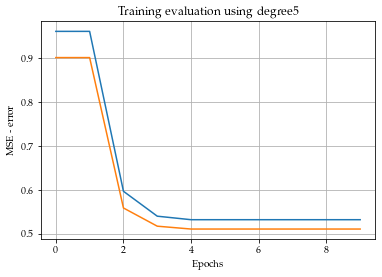

In [7]:
train_loss = np.array(train_loss)
test_loss = np.array(test_loss)
x_plot = np.arange(train_loss.shape[0])

plt.figure()
plt.plot(x_plot, train_loss, label="Train MSE")
plt.plot(x_plot, test_loss, label="Test MSE")
plt.title(f"Training evaluation using degree{degree}")
plt.xlabel("Epochs")
plt.ylabel("MSE - error")
plt.grid()
print(trained_epochs_per_diff)